# bioinvasionanalysis Demo

## How to use this Jupyter notebook

This notebook runs the same bioinvasionanalysis functions as `main.py` and generates the same output files. In addition, it allows for interactive parameter adjustments and visual exploration.

Run each cell sequentially by clicking the ▶ icon or pressing **Shift + Enter**.

Please note:

- Cells titled **"SHOW ..."** generate plots.
- Cells titled **"USER INPUT"** display parameters that you can modify. Press the **"Submit"** button before running the next cell.
- Other cells run bioinvasionanalysis functions. Wait for the message **"Task completed"** before running the next cell.

In [1]:
# USER INPUT
# Check the suggested settings in the form and click "Submit" to save the settings.

import widget_definitions as w
w.params_widget()

In [2]:
# INITIALIZATION

# Load libraries
import os
import sys
from pathlib import Path
from datetime import datetime as dt
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt

# Add the src folder to the Python path
src_path = Path().resolve().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

# Load "bioinvasionanalysis" modules
from thinning import thin
from leastcostpaths import paths
from populations import group_paths, group_points, upper_outlier_fence
from expansionrate import expansion_rate

# Get parameters and set variables
params = w.get_params()
run = params['run']
workdir_path = params['workdir_path']
presence_name = params['presence_name']
year_field = params['year_field']
location_field = params['location_field']
start_year = params['start_year']
end_year = params['end_year']
cost_name = params['cost_name']

# Define dynamic names
in_gpkg = os.path.join(workdir_path, presence_name)
in_lyr_points = presence_name.replace(".gpkg","")
out_gpkg = os.path.join(workdir_path, f"{run}.gpkg")
out_lyr_points = f"{run}_points"
out_lyr_points_thinned = f"{run}_points_thinned"
out_lyr_points_grouped = f"{run}_points_grouped"
out_lyr_paths = f"{run}_paths"
out_lyr_paths_grouped = f"{run}_paths_grouped"
out_csv_sensitivity_test = os.path.join(workdir_path, f"{run}_sensitivity_test.csv")
out_csv_rates = os.path.join(workdir_path, f"{run}_expansion_rates.csv")
out_csv_cumdist = os.path.join(workdir_path, f"{run}_cumulative_distances.csv")

print(f"[{dt.now().strftime('%H:%M:%S')}] Task completed.")

[22:03:01] Task completed.


In [3]:
# PREPARE INPUT DATA

# Load cost surface
in_cost = rio.open(os.path.join(workdir_path, cost_name))

# Load observation data (filtered to cost surface extent and reduced to cost surface resolution)
presence_thinned, cell_size = thin(
    in_gpkg, in_lyr_points, in_cost, out_gpkg, out_lyr_points, out_lyr_points_thinned, 
    year_field, start_year, end_year, location_field
)

print(f"[{dt.now().strftime('%H:%M:%S')}] Task completed.")

[22:03:03] Cost raster has CRS ESRI:102031 and cell size 5000.0 x 5000.0.
[22:03:03] Loading presence data from 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\imexicana_20241227.gpkg'...
[22:03:03] Presence data has CRS EPSG:4326 and 7783 rows, of which 7783 rows with non-null year and geometry.
[22:03:04] Projected presence data to ESRI:102031.
[22:03:04] Applied filter to include presence data within raster extent only.
[22:03:04] Imported presence data saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_points'.
[22:03:04] Creating temporary fishnet with raster properties...
[22:03:15] Joining observations and fishnet polygons...
[22:03:15] Selecting earliest observation per fishnet polygon...
[22:03:16] Thinned imported presence data saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_points_thinned'.
[22:03:16] Task completed.


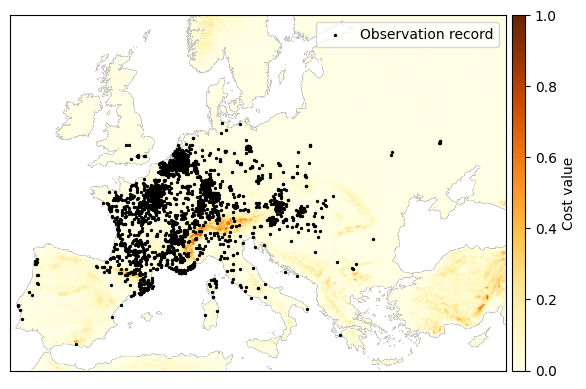

In [4]:
# SHOW INPUT DATA

# Read raster data
extent = [in_cost.bounds.left, in_cost.bounds.right, in_cost.bounds.bottom, in_cost.bounds.top]
cost_arr = in_cost.read(1, masked=True)

# Read coordinates of observation data
x_coords = presence_thinned.geometry.x
y_coords = presence_thinned.geometry.y

# Initialize plot
fig, ax = plt.subplots()

# Plot the raster
cost_lyr = ax.imshow(
    cost_arr,
    extent=extent,
    cmap="YlOrBr"
)

# Define layer (axes) for the colorbar so that we can scale it to match the map height
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

# Add color bar
plt.colorbar(cost_lyr, cax=cax, label="Cost value")

# Plot the observation data
ax.scatter(
    x_coords,
    y_coords,
    facecolor="black",
    s=2,
    label="Observation record"
)

# Turn off the useless coordinate labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.legend()

# Show the plot
plt.show()

In [5]:
# CALCULATE LEAST-COST PATHS

paths = paths(out_gpkg, out_lyr_paths, presence_thinned, in_cost, year_field, start_year, end_year)
print(f"[{dt.now().strftime('%H:%M:%S')}] Task completed.")

[22:03:21] Calculating least-cost paths for year 1994...
[22:03:21] Calculating least-cost paths for year 1995...
[22:03:21] Calculating least-cost paths for year 1996...
[22:03:21] INFO: No path found for a point.
[22:03:21] Calculating least-cost paths for year 1997...
[22:03:21] Calculating least-cost paths for year 1998...
[22:03:21] Calculating least-cost paths for year 1999...
[22:03:21] Calculating least-cost paths for year 2000...
[22:03:21] Calculating least-cost paths for year 2001...
[22:03:21] Calculating least-cost paths for year 2002...
[22:03:21] Calculating least-cost paths for year 2003...
[22:03:21] Calculating least-cost paths for year 2004...
[22:03:21] Calculating least-cost paths for year 2005...
[22:03:21] Calculating least-cost paths for year 2006...
[22:03:21] Calculating least-cost paths for year 2007...
[22:03:22] Calculating least-cost paths for year 2008...
[22:03:22] Calculating least-cost paths for year 2009...
[22:03:22] Calculating least-cost paths for 

In [6]:
# CALCULATE UPPER OUTLIER FENCE FOR ACCUMULATED COST 

outlier_quantile, outlier_fence = upper_outlier_fence(out_gpkg, out_lyr_paths)
print(f"[{dt.now().strftime('%H:%M:%S')}] Task completed.")

[22:03:28] Upper outlier fence (Q3 + 1.5 x IQR) for accumulated cost is 0.047 (Q0.856).
[22:03:28] Task completed.


In [7]:
# USER INPUT
# Check the suggested accumulated cost threshold for population delineation and click "Submit" to save the setting.
# The higher the threshold, the fewer populations are delineated.

w.threshold_widget(outlier_quantile)

In [8]:
# POPULATION DELINEATION

params = w.get_params()
threshold = params['threshold']

paths_grouped = group_paths(out_gpkg, out_lyr_paths, out_lyr_paths_grouped, threshold)
points_grouped = group_points(out_gpkg, out_lyr_points, out_lyr_paths_grouped, out_lyr_points_grouped, cell_size)
print(f"[{dt.now().strftime('%H:%M:%S')}] Task completed.")

[22:03:39] Least-cost paths with accumulated cost < 0.067 (Q0.89) loaded.
[22:03:39] Grouping least-cost paths by their connectivity...
[22:03:40] Grouped least-cost paths saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_paths_grouped'.
[22:03:41] Assigning observations to the groups formed by least-cost paths...
[22:03:41] Grouped observations saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_points_grouped'.
[22:03:41] Task completed.


In [9]:
# CALCULATE EXPANSION RATES

cum_distances, exp_rates = expansion_rate(out_gpkg, out_lyr_points_grouped, out_csv_rates, out_csv_cumdist, year_field)
print(f"[{dt.now().strftime('%H:%M:%S')}] Task completed.")

[22:03:45] Calculating expansion rates for groups (populations)...


C:\Users\Christa\Documents\Git\py-3-10\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


[22:03:46] Raw data saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo_cumulative_distances.csv'.
[22:03:46] Expansion rates saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo_expansion_rates.csv'.
[22:03:46] Task completed.


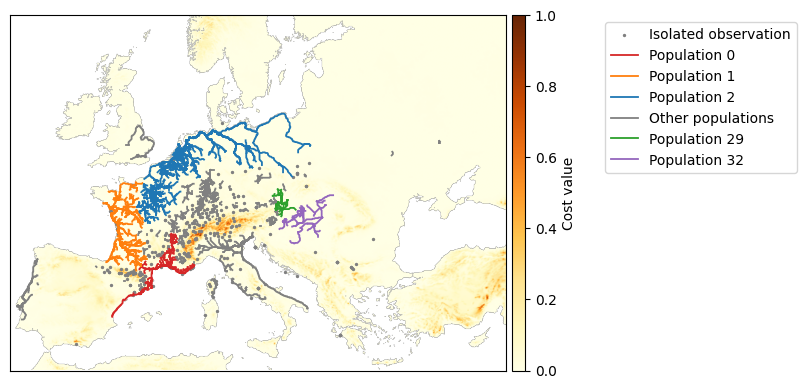

In [10]:
# SHOW POPULATIONS
# Only the five populations with the highest median observation count per year are shown in detail.

# Ensure group_id in paths_grouped is a string
paths_grouped["group_id"] = paths_grouped["group_id"].astype(str)

# Filter points_grouped to include only rows where group_id is null
points_isolated = points_grouped[points_grouped["group_id"].isnull()]

# Identify the top 5 groups
top_groups = (
    exp_rates.sort_values(by="median_points_per_year", ascending=False)
    .head(5)["group_id"]
    .tolist()
)

# Assign colors for top groups and grey for others
colors = plt.cm.tab10.colors  # Categorical colormap
group_colors = {group: colors[i % len(colors)] for i, group in enumerate(top_groups)}
default_color = "grey"

# Initialize plot
fig, ax = plt.subplots()

# Plot the raster
cost_lyr = ax.imshow(cost_arr, extent=extent, cmap="YlOrBr")

# Add color bar with proper scaling
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(cost_lyr, cax=cax, label="Cost value")

# Plot isolated observations
ax.scatter(
    points_isolated.geometry.x,
    points_isolated.geometry.y,
    color="grey",
    s=2,
    label="Isolated observation"
)

# Track seen labels to avoid duplicates
added_labels = set()

# Plot least-cost paths
for _, row in paths_grouped.iterrows():
    path_group_id = row["group_id"]
    path_color = group_colors.get(path_group_id, default_color)

    # Assign labels dynamically for categorized groups, other groups, and isolated observations
    if path_group_id in top_groups:
        label = f"Population {path_group_id}" if f"Population {path_group_id}" not in added_labels else None
    else:
        label = "Other populations" if "Other populations" not in added_labels else None

    # Add to seen labels
    if label:
        added_labels.add(label)

    # Plot paths
    if row.geometry.geom_type == "MultiLineString":
        for line in row.geometry.geoms:
            ax.plot(*line.xy, color=path_color, linewidth=1.3, label=label)
    elif row.geometry.geom_type == "LineString":
        ax.plot(*row.geometry.xy, color=path_color, linewidth=1.3, label=label)

# Turn off the useless coordinate labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Add the legend
ax.legend(loc="upper right", bbox_to_anchor=(1.6, 1))

# Show the plot
plt.show()

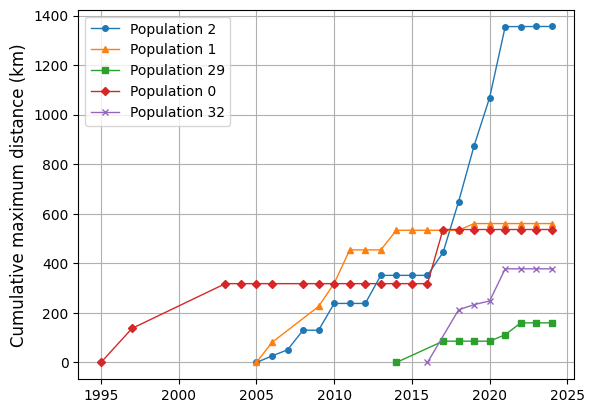

In [11]:
# SHOW EXPANSION RATES

# Filter the cumulative distances and expansion rates for the top groups
cum_distances_top = cum_distances[cum_distances["group_id"].isin(top_groups)]
exp_rates_top = exp_rates[exp_rates["group_id"].isin(top_groups)]

# Assign markers for top groups
marker_styles = ["o", "^", "s", "D", "x", "P", "*", "v", "h", "8"]  # Extendable list of markers
group_markers = {group: marker_styles[i % len(marker_styles)] for i, group in enumerate(top_groups)}

# Initialize plot
fig, ax = plt.subplots()

# Plot lines for each group
for group_id in top_groups:
    group_data = cum_distances_top[cum_distances_top["group_id"] == group_id]
    ax.plot(
        group_data["year"],
        group_data["max_distance"]/1000,
        label=f"Population {group_id}",
        color=group_colors[group_id],  # Use matching colors from the map
        marker=group_markers[group_id],  # Use matching marker from the map
        linewidth=1,
        markersize=4
    )

# Add labels, legend, and title
ax.grid()
ax.set_ylabel("Cumulative maximum distance (km)", fontsize=12)
ax.legend(loc="upper left")
plt.show()

In [12]:
# SHOW RESULT TABLE

# Filter for the top groups
exp_rates_top = exp_rates[exp_rates["group_id"].isin(top_groups)]

exp_rates_top = exp_rates_top.rename(columns={
    "group_id": "Population",
    "min_year": "From (year)",
    "max_year": "Until (year)",
    "point_count": "Observation count (n)",
    "median_points_per_year": "Median obs./year (n/year)",
    "expansion_rate": "Expansion rate (km/year)",
    "r2": "OLS model strength (R²)"
})

exp_rates_top.style.format({
    "From (year)": "{:.0f}",
    "Until (year)": "{:.0f}",
    "Median obs./year (n/year)": "{:.1f}",
    "Expansion rate (km/year)": lambda x: f"{x / 1000:.1f}",
    "OLS model strength (R²)": "{:.2f}"
}).set_table_styles([
    {"selector": "th", "props": [("font-weight", "bold")]}
]).hide(axis="index")

Population,From (year),Until (year),Observation count (n),Median obs./year (n/year),Expansion rate (km/year),OLS model strength (R²)
0,1995,2024,454,18.0,18.9,0.71
1,2005,2024,568,25.0,16.4,0.66
2,2005,2024,3951,101.5,108.8,0.90
29,2014,2024,181,21.0,16.1,0.80
32,2016,2024,109,15.0,38.4,0.70
